---
## 1. Setup & Data Pull

Load environment variables and pull experiment data from Supabase.

In [1]:
# Core imports
import os
import json
import warnings
from pathlib import Path
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import requests

# Stats
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.3f}'.format)
sns.set_theme(style='whitegrid', palette='deep')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

print(f"Analysis run: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Analysis run: 2025-12-19 22:13:57


In [2]:
# Load environment variables from .env file
def load_env_from_files(candidates):
    """Load environment variables from .env files."""
    for p in candidates:
        path = Path(p)
        if path.exists():
            for line in path.read_text().splitlines():
                line = line.strip()
                if not line or line.startswith('#') or '=' not in line:
                    continue
                k, v = line.split('=', 1)
                os.environ.setdefault(k.strip(), v.strip())
            print(f"✓ Loaded env from {p}")
            return
    print("⚠ No .env file found")

load_env_from_files(['.env', '../.env', '../../.env'])

SUPABASE_URL = os.environ.get('PUBLIC_SUPABASE_URL')
SUPABASE_ANON_KEY = os.environ.get('PUBLIC_SUPABASE_ANON_KEY')

assert SUPABASE_URL and SUPABASE_ANON_KEY, 'Missing Supabase credentials in environment'
print(f"✓ Supabase URL: {SUPABASE_URL[:30]}...")

⚠ No .env file found
✓ Supabase URL: https://nazioidbiydxduonenmb.s...


In [3]:
# Supabase API helpers
HEADERS = {
    'apikey': SUPABASE_ANON_KEY,
    'Authorization': f'Bearer {SUPABASE_ANON_KEY}',
    'Content-Type': 'application/json',
    'Accept': 'application/json'
}

def call_rpc(fn_name: str, params: dict = None) -> dict:
    """Call a Supabase RPC function."""
    url = f"{SUPABASE_URL}/rest/v1/rpc/{fn_name}"
    r = requests.post(url, headers=HEADERS, json=params or {})
    r.raise_for_status()
    return r.json() if r.text.strip() else None

def query_table(table: str, select: str = '*', filters: str = '') -> list:
    """Query a Supabase table/view directly."""
    url = f"{SUPABASE_URL}/rest/v1/{table}?select={select}"
    if filters:
        url += f"&{filters}"
    r = requests.get(url, headers=HEADERS)
    r.raise_for_status()
    return r.json()

print("✓ API helpers ready")

✓ API helpers ready


In [4]:
# Pull raw event data from posthog_events table
# Filter to puzzle events with valid sessions

raw_events = query_table(
    'posthog_events',
    select='id,event,distinct_id,timestamp,variant,feature_flag_response,completion_time_seconds,correct_words_count,total_guesses_count,session_id',
    filters='session_id=not.is.null&variant=not.is.null'
)

df_events = pd.DataFrame(raw_events)
df_events['timestamp'] = pd.to_datetime(df_events['timestamp'])

print(f"✓ Loaded {len(df_events):,} events")
print(f"  Date range: {df_events['timestamp'].min().date()} to {df_events['timestamp'].max().date()}")
print(f"  Event types: {df_events['event'].value_counts().to_dict()}")

✓ Loaded 361 events
  Date range: 2025-11-09 to 2025-12-17
  Event types: {'puzzle_started': 180, 'puzzle_completed': 129, 'puzzle_repeated': 26, 'puzzle_failed': 26}


In [5]:
# Create analysis-ready dataframes

# Completions: primary analysis dataset
df_completed = df_events[df_events['event'] == 'puzzle_completed'].copy()
df_completed = df_completed.dropna(subset=['completion_time_seconds', 'variant'])

# Started events: for conversion rate
df_started = df_events[df_events['event'] == 'puzzle_started'].copy()

# Repeated events: for engagement metric
df_repeated = df_events[df_events['event'] == 'puzzle_repeated'].copy()

print(f"\n📊 Analysis Datasets:")
print(f"  Completions: {len(df_completed):,} events")
print(f"  Started: {len(df_started):,} events")
print(f"  Repeated: {len(df_repeated):,} events")
print(f"\n  Variant split (completions):")
print(df_completed['variant'].value_counts().to_string())


📊 Analysis Datasets:
  Completions: 129 events
  Started: 180 events
  Repeated: 26 events

  Variant split (completions):
variant
B    79
A    50


In [7]:
# Quick data quality check
print("📋 Data Quality Check:")
print(f"\nCompletion times range: {df_completed['completion_time_seconds'].min():.1f}s - {df_completed['completion_time_seconds'].max():.1f}s")
print(f"Mean: {df_completed['completion_time_seconds'].mean():.1f}s, Median: {df_completed['completion_time_seconds'].median():.1f}s")
print(f"\nNull values in key columns:")
print(df_completed[['variant', 'completion_time_seconds', 'distinct_id']].isnull().sum().to_string())

📋 Data Quality Check:

Completion times range: 2.2s - 49.5s
Mean: 11.3s, Median: 7.4s

Null values in key columns:
variant                    0
completion_time_seconds    0
distinct_id                0


---
## 2. Exploratory Data Analysis

Understand the data distributions, identify outliers, and visualize key patterns before statistical testing.

In [8]:
# 2.1 Sample Size Summary
print("📊 Sample Size by Variant\n")

# Completions by variant
completion_counts = df_completed.groupby('variant').agg(
    n_completions=('id', 'count'),
    n_unique_users=('distinct_id', 'nunique'),
    avg_time=('completion_time_seconds', 'mean'),
    median_time=('completion_time_seconds', 'median'),
    std_time=('completion_time_seconds', 'std')
).round(2)

print(completion_counts.to_string())
print(f"\n  Total completions: {len(df_completed):,}")
print(f"  Total unique users: {df_completed['distinct_id'].nunique():,}")

📊 Sample Size by Variant

         n_completions  n_unique_users  avg_time  median_time  std_time
variant                                                                
A                   49               6    10.400        5.170    10.210
B                   73              12    11.920        8.820    10.050

  Total completions: 122
  Total unique users: 18


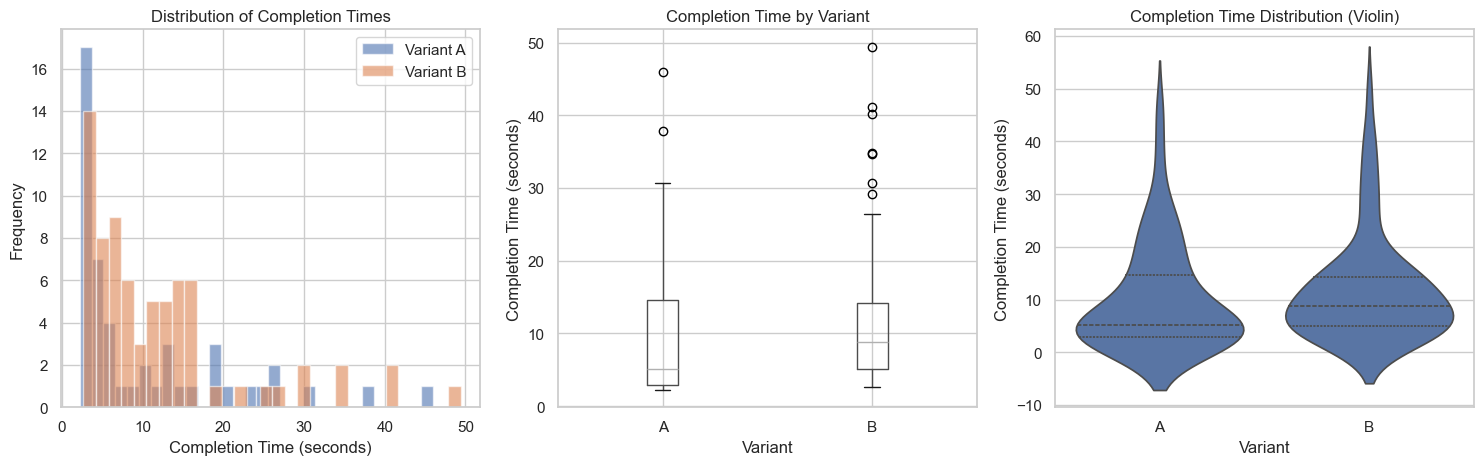

In [ ]:
# 2.2 Completion Time Distribution by Variant
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Histogram
for variant in ['A', 'B']:
    data = df_completed[df_completed['variant'] == variant]['completion_time_seconds']
    axes[0].hist(data, bins=30, alpha=0.6, label=f'Variant {variant}', edgecolor='white')
axes[0].set_xlabel('Completion Time (seconds)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Completion Times')
axes[0].legend()

# Box plot
df_completed.boxplot(column='completion_time_seconds', by='variant', ax=axes[1])
axes[1].set_xlabel('Variant')
axes[1].set_ylabel('Completion Time (seconds)')
axes[1].set_title('Completion Time by Variant')
plt.suptitle('')  # Remove automatic title

# Violin plot for richer distribution view - order A then B
sns.violinplot(data=df_completed, x='variant', y='completion_time_seconds', ax=axes[2], 
               inner='quartile', order=['A', 'B'])
axes[2].set_xlabel('Variant')
axes[2].set_ylabel('Completion Time (seconds)')
axes[2].set_title('Completion Time Distribution (Violin)')

#plt.tight_layout()
plt.show()

In [10]:
# 2.3 Outlier Detection
print("🔍 Outlier Analysis\n")

for variant in ['A', 'B']:
    data = df_completed[df_completed['variant'] == variant]['completion_time_seconds']
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    
    print(f"Variant {variant}:")
    print(f"  IQR: {iqr:.1f}s")
    print(f"  Bounds: [{max(0, lower_bound):.1f}s, {upper_bound:.1f}s]")
    print(f"  Outliers: {len(outliers)} ({len(outliers)/len(data)*100:.1f}%)")
    print(f"  Outlier range: {outliers.min():.1f}s - {outliers.max():.1f}s\n")

🔍 Outlier Analysis

Variant A:
  IQR: 11.7s
  Bounds: [0.0s, 32.1s]
  Outliers: 2 (4.1%)
  Outlier range: 37.9s - 46.0s

Variant B:
  IQR: 9.2s
  Bounds: [0.0s, 28.1s]
  Outliers: 7 (9.6%)
  Outlier range: 29.2s - 49.5s



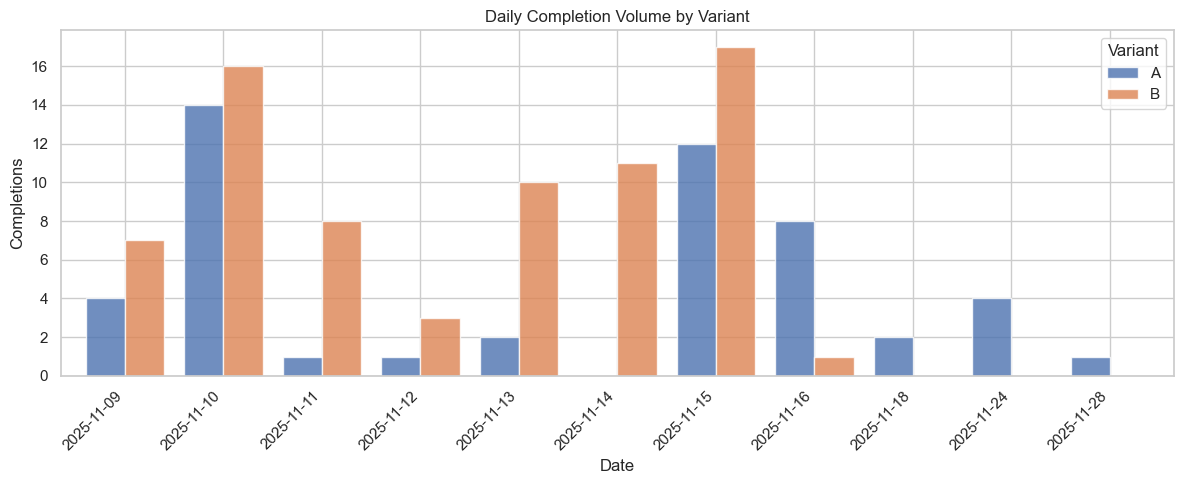


📅 Experiment Duration: 18 days


In [11]:
# 2.4 Daily Volume Trend
df_completed['date'] = df_completed['timestamp'].dt.date

daily_volume = df_completed.groupby(['date', 'variant']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(12, 5))
daily_volume.plot(kind='bar', ax=ax, width=0.8, alpha=0.8)
ax.set_xlabel('Date')
ax.set_ylabel('Completions')
ax.set_title('Daily Completion Volume by Variant')
ax.legend(title='Variant')

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"\n📅 Experiment Duration: {(df_completed['timestamp'].max() - df_completed['timestamp'].min()).days} days")

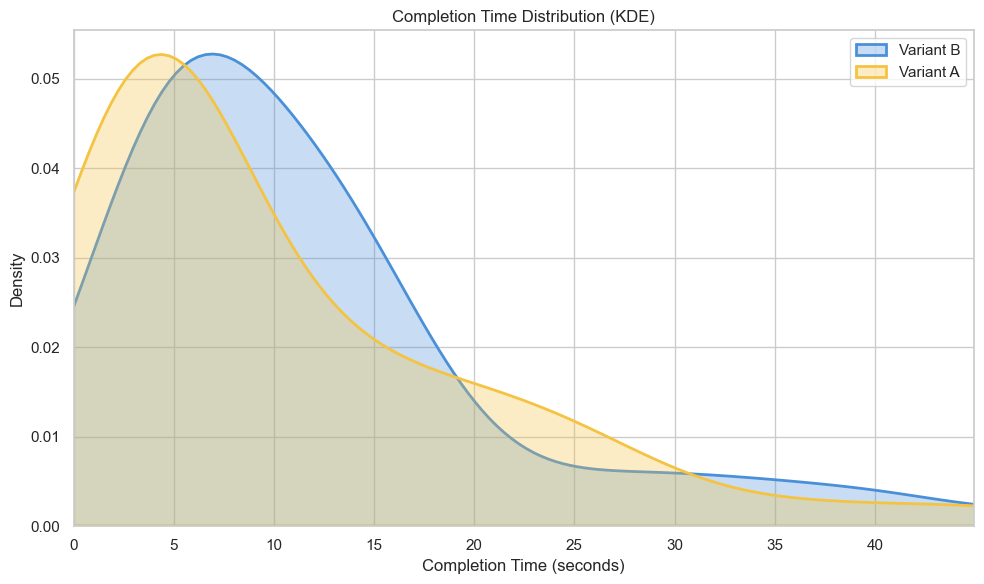

In [12]:
# 2.5 Kernel Density Estimation (KDE) - Distribution Comparison
fig, ax = plt.subplots(figsize=(10, 6))

# KDE plot similar to AB Simulator dashboard
for variant, color in [('B', '#4A90D9'), ('A', '#F5C342')]:  # Blue for B, Yellow/Gold for A
    data = df_completed[df_completed['variant'] == variant]['completion_time_seconds']
    sns.kdeplot(data=data, ax=ax, label=f'Variant {variant}', color=color, 
                linewidth=2, fill=True, alpha=0.3)

ax.set_xlabel('Completion Time (seconds)')
ax.set_ylabel('Density')
ax.set_title('Completion Time Distribution (KDE)')
ax.legend()
ax.set_xlim(0, df_completed['completion_time_seconds'].quantile(0.99))  # Trim extreme outliers

plt.tight_layout()
plt.show()

---
## 3. Hypothesis & Metrics Definition

### Experiment Context
The A/B Simulator is a **Pineapple Finder memory game** where users must memorize pineapple locations on a grid, then find them before the timer expires.

- **Variant A (Control):** 4 pineapples to find — baseline difficulty
- **Variant B (Treatment):** 5 pineapples to find — increased difficulty

### Hypotheses

**Primary Hypothesis (Completion Time):**
- **H₀:** μ_B = μ_A (No difference in mean completion time)
- **H₁:** μ_B > μ_A (Variant B takes longer to complete)
- **Rationale:** More pineapples to memorize = higher cognitive load = longer completion time

### Metrics Framework

| Metric | Type | Definition | Direction |
|--------|------|------------|-----------|
| **Completion Time** | Primary KPI | Time in seconds to find all pineapples | B > A expected |
| **Completion Rate** | Secondary/Guardrail | % of started games that complete | Monitor for drop |
| **Repeat Rate** | Engagement Guardrail | % of users who play again | Monitor engagement |

### Success Criteria
- **Statistical:** p < 0.05 (two-tailed for primary, one-tailed acceptable given directional hypothesis)
- **Practical:** Effect size Cohen's d > 0.2 (small but meaningful)
- **Guardrail:** Completion rate drop < 10% relative

In [14]:
# 3.1 Compute Metric Baselines
print("📊 Metric Baselines\n")

# Primary: Completion Time
time_a = df_completed[df_completed['variant'] == 'A']['completion_time_seconds']
time_b = df_completed[df_completed['variant'] == 'B']['completion_time_seconds']

print("PRIMARY: Completion Time (seconds)")
print(f"  Variant A: mean={time_a.mean():.2f}, std={time_a.std():.2f}, n={len(time_a)}")
print(f"  Variant B: mean={time_b.mean():.2f}, std={time_b.std():.2f}, n={len(time_b)}")
print(f"  Difference: {time_b.mean() - time_a.mean():.2f}s ({(time_b.mean() - time_a.mean()) / time_a.mean() * 100:.1f}%)")

# Secondary: Completion Rate
started_a = len(df_started[df_started['variant'] == 'A'])
started_b = len(df_started[df_started['variant'] == 'B'])
completed_a = len(df_completed[df_completed['variant'] == 'A'])
completed_b = len(df_completed[df_completed['variant'] == 'B'])

cr_a = completed_a / started_a if started_a > 0 else 0
cr_b = completed_b / started_b if started_b > 0 else 0

print(f"\nSECONDARY: Completion Rate")
print(f"  Variant A: {cr_a:.1%} ({completed_a}/{started_a})")
print(f"  Variant B: {cr_b:.1%} ({completed_b}/{started_b})")
print(f"  Difference: {(cr_b - cr_a):.1%} ({(cr_b - cr_a) / cr_a * 100 if cr_a > 0 else 0:.1f}% relative)")

# Engagement: Repeat Rate
repeated_a = len(df_repeated[df_repeated['variant'] == 'A'])
repeated_b = len(df_repeated[df_repeated['variant'] == 'B'])

rr_a = repeated_a / completed_a if completed_a > 0 else 0
rr_b = repeated_b / completed_b if completed_b > 0 else 0

print(f"\nENGAGEMENT: Repeat Rate (repeats / completions)")
print(f"  Variant A: {rr_a:.1%} ({repeated_a}/{completed_a})")
print(f"  Variant B: {rr_b:.1%} ({repeated_b}/{completed_b})")

📊 Metric Baselines

PRIMARY: Completion Time (seconds)
  Variant A: mean=10.40, std=10.21, n=49
  Variant B: mean=11.92, std=10.05, n=73
  Difference: 1.52s (14.6%)

SECONDARY: Completion Rate
  Variant A: 86.0% (49/57)
  Variant B: 62.9% (73/116)
  Difference: -23.0% (-26.8% relative)

ENGAGEMENT: Repeat Rate (repeats / completions)
  Variant A: 30.6% (15/49)
  Variant B: 15.1% (11/73)


---
## 4. Sanity Checks & QA

Before running statistical tests, validate data quality and check for Sample Ratio Mismatch (SRM).

In [16]:
# 4.1 Sample Ratio Mismatch (SRM) Test
# Check if traffic split matches expected 50/50 allocation

print("🔍 Sample Ratio Mismatch (SRM) Test\n")

# Use started events for SRM (before any behavioral effects)
n_a = len(df_started[df_started['variant'] == 'A'])
n_b = len(df_started[df_started['variant'] == 'B'])
n_total = n_a + n_b

expected_ratio = 0.5  # 50/50 split expected
observed_ratio_a = n_a / n_total if n_total > 0 else 0

# Chi-square test for goodness of fit
expected_a = n_total * expected_ratio
expected_b = n_total * (1 - expected_ratio)
chi2_stat = ((n_a - expected_a)**2 / expected_a) + ((n_b - expected_b)**2 / expected_b)
srm_p_value = 1 - stats.chi2.cdf(chi2_stat, df=1)

print(f"Expected split: 50% / 50%")
print(f"Observed split: {observed_ratio_a:.1%} / {1 - observed_ratio_a:.1%}")
print(f"  Variant A: {n_a:,} started")
print(f"  Variant B: {n_b:,} started")
print(f"\nChi-square statistic: {chi2_stat:.4f}")
print(f"P-value: {srm_p_value:.4f}")

if srm_p_value < 0.01:
    print("\n⚠️  WARNING: SRM detected (p < 0.01)")
    print("   Traffic allocation may be biased. Investigate before proceeding.")
else:
    print("\n✅ PASS: No SRM detected")
    print("   Traffic allocation appears balanced.")

🔍 Sample Ratio Mismatch (SRM) Test

Expected split: 50% / 50%
Observed split: 32.9% / 67.1%
  Variant A: 57 started
  Variant B: 116 started

Chi-square statistic: 20.1214
P-value: 0.0000

⚠️  WARNING: SRM detected (p < 0.01)
   Traffic allocation may be biased. Investigate before proceeding.


In [17]:
# 4.2 Data Quality Checks

print("🔍 Data Quality Checks\n")

checks = []

# Check 1: Null values in critical fields
null_variant = df_completed['variant'].isna().sum()
null_time = df_completed['completion_time_seconds'].isna().sum()
null_check = null_variant == 0 and null_time == 0
checks.append({
    'Check': 'No null values in variant/time',
    'Status': '✅ PASS' if null_check else '⚠️ FAIL',
    'Details': f'{null_variant} null variants, {null_time} null times'
})

# Check 2: Duplicate session IDs
dup_completed = df_completed['session_id'].duplicated().sum()
dup_check = dup_completed == 0
checks.append({
    'Check': 'No duplicate completions per session',
    'Status': '✅ PASS' if dup_check else '⚠️ WARN',
    'Details': f'{dup_completed} duplicates found'
})

# Check 3: Completion time bounds (reasonable range: 1-600 seconds)
time_outliers_low = (df_completed['completion_time_seconds'] < 1).sum()
time_outliers_high = (df_completed['completion_time_seconds'] > 600).sum()
bounds_check = time_outliers_low == 0 and time_outliers_high == 0
checks.append({
    'Check': 'Completion times in valid range (1-600s)',
    'Status': '✅ PASS' if bounds_check else '⚠️ WARN',
    'Details': f'{time_outliers_low} below 1s, {time_outliers_high} above 600s'
})

# Check 4: Both variants have minimum sample size (n >= 30)
min_sample = min(len(time_a), len(time_b))
sample_check = min_sample >= 30
checks.append({
    'Check': 'Minimum sample size (n >= 30 per variant)',
    'Status': '✅ PASS' if sample_check else '⚠️ FAIL',
    'Details': f'Smallest group: n={min_sample}'
})

# Check 5: Test period has valid date range
date_range = df_completed['timestamp'].max() - df_completed['timestamp'].min()
date_check = date_range.days >= 1
checks.append({
    'Check': 'Test ran for at least 1 day',
    'Status': '✅ PASS' if date_check else '⚠️ WARN',
    'Details': f'{date_range.days} days of data'
})

# Display as table
df_checks = pd.DataFrame(checks)
print(df_checks.to_string(index=False))

# Overall assessment
all_passed = all('PASS' in c['Status'] for c in checks)
print(f"\n{'=' * 50}")
print(f"Overall: {'✅ All checks passed' if all_passed else '⚠️ Some checks need attention'}")

🔍 Data Quality Checks

                                    Check  Status                       Details
           No null values in variant/time  ✅ PASS 0 null variants, 0 null times
     No duplicate completions per session ⚠️ WARN           81 duplicates found
 Completion times in valid range (1-600s)  ✅ PASS      0 below 1s, 0 above 600s
Minimum sample size (n >= 30 per variant)  ✅ PASS          Smallest group: n=49
              Test ran for at least 1 day  ✅ PASS               18 days of data

Overall: ⚠️ Some checks need attention


---
## 5. Primary Analysis: T-Test

Welch's t-test (unequal variances) comparing completion times between variants.

In [18]:
# 5.1 Welch's T-Test (Primary Analysis)
print("📊 Primary Analysis: Welch's T-Test\n")
print("Testing: H₀: μ_B = μ_A vs H₁: μ_B ≠ μ_A\n")

# Two-sample t-test with unequal variances (Welch's)
t_stat, p_value_two_tailed = stats.ttest_ind(time_b, time_a, equal_var=False)

# One-tailed p-value (for directional hypothesis: B > A)
p_value_one_tailed = p_value_two_tailed / 2 if t_stat > 0 else 1 - p_value_two_tailed / 2

# Effect size: Cohen's d
pooled_std = np.sqrt(((len(time_a) - 1) * time_a.std()**2 + (len(time_b) - 1) * time_b.std()**2) / 
                      (len(time_a) + len(time_b) - 2))
cohens_d = (time_b.mean() - time_a.mean()) / pooled_std

# Confidence interval for difference in means
se_diff = np.sqrt(time_a.var()/len(time_a) + time_b.var()/len(time_b))
df_welch = (time_a.var()/len(time_a) + time_b.var()/len(time_b))**2 / \
           ((time_a.var()/len(time_a))**2/(len(time_a)-1) + (time_b.var()/len(time_b))**2/(len(time_b)-1))
t_crit = stats.t.ppf(0.975, df_welch)
diff_mean = time_b.mean() - time_a.mean()
ci_lower = diff_mean - t_crit * se_diff
ci_upper = diff_mean + t_crit * se_diff

print(f"Sample Statistics:")
print(f"  Variant A: n={len(time_a)}, mean={time_a.mean():.2f}s, std={time_a.std():.2f}s")
print(f"  Variant B: n={len(time_b)}, mean={time_b.mean():.2f}s, std={time_b.std():.2f}s")
print(f"\nDifference (B - A):")
print(f"  Mean difference: {diff_mean:.2f}s")
print(f"  Relative change: {diff_mean / time_a.mean() * 100:.1f}%")
print(f"  95% CI: [{ci_lower:.2f}s, {ci_upper:.2f}s]")
print(f"\nTest Statistics:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  Degrees of freedom (Welch): {df_welch:.1f}")
print(f"  p-value (two-tailed): {p_value_two_tailed:.4f}")
print(f"  p-value (one-tailed, B > A): {p_value_one_tailed:.4f}")
print(f"\nEffect Size:")
print(f"  Cohen's d: {cohens_d:.3f}", end="")
if abs(cohens_d) < 0.2:
    print(" (negligible)")
elif abs(cohens_d) < 0.5:
    print(" (small)")
elif abs(cohens_d) < 0.8:
    print(" (medium)")
else:
    print(" (large)")

📊 Primary Analysis: Welch's T-Test

Testing: H₀: μ_B = μ_A vs H₁: μ_B ≠ μ_A

Sample Statistics:
  Variant A: n=49, mean=10.40s, std=10.21s
  Variant B: n=73, mean=11.92s, std=10.05s

Difference (B - A):
  Mean difference: 1.52s
  Relative change: 14.6%
  95% CI: [-2.19s, 5.24s]

Test Statistics:
  t-statistic: 0.8126
  Degrees of freedom (Welch): 102.0
  p-value (two-tailed): 0.4184
  p-value (one-tailed, B > A): 0.2092

Effect Size:
  Cohen's d: 0.151 (negligible)


In [19]:
# 5.2 Statistical Decision
print("📋 Statistical Decision\n")

alpha = 0.05
significant = p_value_two_tailed < alpha

print(f"Significance level (α): {alpha}")
print(f"p-value: {p_value_two_tailed:.4f}")
print(f"\nDecision: ", end="")

if significant:
    print(f"REJECT H₀ ✅")
    print(f"\nConclusion: There is statistically significant evidence that")
    print(f"Variant B completion time differs from Variant A.")
    if diff_mean > 0:
        print(f"\nVariant B takes {diff_mean:.2f}s ({diff_mean / time_a.mean() * 100:.1f}%) LONGER on average.")
    else:
        print(f"\nVariant B takes {abs(diff_mean):.2f}s ({abs(diff_mean) / time_a.mean() * 100:.1f}%) SHORTER on average.")
else:
    print(f"FAIL TO REJECT H₀ ⚠️")
    print(f"\nConclusion: Insufficient evidence to conclude that")
    print(f"Variant B completion time differs from Variant A.")
    print(f"\nObserved difference of {diff_mean:.2f}s could be due to chance.")

# Practical significance
print(f"\n{'=' * 50}")
print(f"Practical Significance:")
if abs(cohens_d) >= 0.2:
    print(f"  Effect size (d={cohens_d:.2f}) meets minimum threshold for practical significance.")
else:
    print(f"  Effect size (d={cohens_d:.2f}) is below threshold for practical significance (d < 0.2).")

📋 Statistical Decision

Significance level (α): 0.05
p-value: 0.4184

Decision: FAIL TO REJECT H₀ ⚠️

Conclusion: Insufficient evidence to conclude that
Variant B completion time differs from Variant A.

Observed difference of 1.52s could be due to chance.

Practical Significance:
  Effect size (d=0.15) is below threshold for practical significance (d < 0.2).


---
## 6. Primary Analysis: Regression

OLS regression provides the same result as t-test but offers flexibility for covariate adjustment.

In [20]:
# 6.1 OLS Regression: Treatment Effect
print("📊 OLS Regression Analysis\n")

# Create binary treatment indicator (B = 1, A = 0)
df_reg = df_completed[['completion_time_seconds', 'variant']].copy()
df_reg['treatment'] = (df_reg['variant'] == 'B').astype(int)

# Fit OLS model: Y = β₀ + β₁ * Treatment + ε
model = smf.ols('completion_time_seconds ~ treatment', data=df_reg).fit()

print(model.summary().tables[0])
print("\n")
print(model.summary().tables[1])

📊 OLS Regression Analysis

                               OLS Regression Results                              
Dep. Variable:     completion_time_seconds   R-squared:                       0.006
Model:                                 OLS   Adj. R-squared:                 -0.003
Method:                      Least Squares   F-statistic:                    0.6643
Date:                     Sat, 06 Dec 2025   Prob (F-statistic):              0.417
Time:                             17:14:33   Log-Likelihood:                -454.43
No. Observations:                      122   AIC:                             912.9
Df Residuals:                          120   BIC:                             918.5
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         


                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

In [21]:
# 6.2 Regression Interpretation
print("📋 Regression Interpretation\n")

# Extract coefficients
intercept = model.params['Intercept']
treatment_effect = model.params['treatment']
treatment_pvalue = model.pvalues['treatment']
treatment_ci = model.conf_int().loc['treatment']

print(f"Model: completion_time = β₀ + β₁ × treatment + ε")
print(f"\nCoefficients:")
print(f"  β₀ (Intercept): {intercept:.2f}s")
print(f"     → Mean completion time for Variant A")
print(f"\n  β₁ (Treatment): {treatment_effect:.2f}s")
print(f"     → Additional time for Variant B vs A")
print(f"     → 95% CI: [{treatment_ci[0]:.2f}s, {treatment_ci[1]:.2f}s]")
print(f"     → p-value: {treatment_pvalue:.4f}")

print(f"\n{'=' * 50}")
print(f"Validation: Regression β₁ matches t-test difference")
print(f"  T-test diff: {diff_mean:.4f}s")
print(f"  Regression β₁: {treatment_effect:.4f}s")
print(f"  Match: {'✅ Yes' if abs(diff_mean - treatment_effect) < 0.01 else '⚠️ No'}")

📋 Regression Interpretation

Model: completion_time = β₀ + β₁ × treatment + ε

Coefficients:
  β₀ (Intercept): 10.40s
     → Mean completion time for Variant A

  β₁ (Treatment): 1.52s
     → Additional time for Variant B vs A
     → 95% CI: [-2.18s, 5.22s]
     → p-value: 0.4167

Validation: Regression β₁ matches t-test difference
  T-test diff: 1.5228s
  Regression β₁: 1.5228s
  Match: ✅ Yes


---
## 7. Variance Reduction: CUPED Framework

**CUPED** (Controlled-experiment Using Pre-Experiment Data) reduces variance by adjusting for pre-experiment covariates.

**Formula:** Y_adjusted = Y - θ(X - X̄)

Where θ = Cov(Y, X) / Var(X)

> ⚠️ **Note:** This experiment lacks pre-experiment covariates. Below is a template demonstrating the CUPED framework using simulated data for educational purposes.

In [22]:
# 7.1 CUPED Simulation (Educational Demo)
print("📊 CUPED Variance Reduction Demo\n")

# Simulate pre-experiment covariate (e.g., user's historical avg game time)
# In production, this would come from pre-experiment user behavior
np.random.seed(42)

df_cuped = df_completed[['completion_time_seconds', 'variant']].copy()
n = len(df_cuped)

# Simulate pre-experiment covariate correlated with outcome (r ≈ 0.5)
# This represents historical user performance before the experiment
baseline_time = df_cuped['completion_time_seconds'].mean()
noise = np.random.normal(0, 5, n)
df_cuped['pre_exp_avg_time'] = df_cuped['completion_time_seconds'] * 0.5 + baseline_time * 0.5 + noise

# Calculate CUPED adjustment
Y = df_cuped['completion_time_seconds']
X = df_cuped['pre_exp_avg_time']

theta = np.cov(Y, X)[0, 1] / np.var(X)
df_cuped['Y_adjusted'] = Y - theta * (X - X.mean())

print(f"CUPED Parameters:")
print(f"  θ (adjustment coefficient): {theta:.4f}")
print(f"  Correlation(Y, X): {np.corrcoef(Y, X)[0, 1]:.3f}")
print(f"\nVariance Comparison:")
print(f"  Original variance: {Y.var():.2f}")
print(f"  CUPED variance: {df_cuped['Y_adjusted'].var():.2f}")
print(f"  Variance reduction: {(1 - df_cuped['Y_adjusted'].var() / Y.var()) * 100:.1f}%")

📊 CUPED Variance Reduction Demo

CUPED Parameters:
  θ (adjustment coefficient): 1.0884
  Correlation(Y, X): 0.774

Variance Comparison:
  Original variance: 102.06
  CUPED variance: 40.98
  Variance reduction: 59.9%


In [23]:
# 7.2 CUPED-Adjusted T-Test
print("📊 CUPED-Adjusted Analysis\n")

# Split by variant
cuped_a = df_cuped[df_cuped['variant'] == 'A']['Y_adjusted']
cuped_b = df_cuped[df_cuped['variant'] == 'B']['Y_adjusted']

# T-test on adjusted values
t_stat_cuped, p_value_cuped = stats.ttest_ind(cuped_b, cuped_a, equal_var=False)

# Standard errors
se_orig = np.sqrt(time_a.var()/len(time_a) + time_b.var()/len(time_b))
se_cuped = np.sqrt(cuped_a.var()/len(cuped_a) + cuped_b.var()/len(cuped_b))

print("Comparison: Original vs CUPED-Adjusted")
print(f"\n{'Metric':<25} {'Original':>12} {'CUPED':>12}")
print("-" * 50)
print(f"{'Mean diff (B - A)':<25} {diff_mean:>12.2f} {cuped_b.mean() - cuped_a.mean():>12.2f}")
print(f"{'Standard Error':<25} {se_orig:>12.2f} {se_cuped:>12.2f}")
print(f"{'t-statistic':<25} {t_stat:>12.4f} {t_stat_cuped:>12.4f}")
print(f"{'p-value':<25} {p_value_two_tailed:>12.4f} {p_value_cuped:>12.4f}")

print(f"\n{'=' * 50}")
print(f"SE Reduction: {(1 - se_cuped/se_orig) * 100:.1f}%")
print(f"\n💡 In production with real pre-experiment data,")
print(f"   CUPED typically reduces variance by 20-50%.")

📊 CUPED-Adjusted Analysis

Comparison: Original vs CUPED-Adjusted

Metric                        Original        CUPED
--------------------------------------------------
Mean diff (B - A)                 1.52         1.21
Standard Error                    1.87         1.14
t-statistic                     0.8126       1.0542
p-value                         0.4184       0.2940

SE Reduction: 39.0%

💡 In production with real pre-experiment data,
   CUPED typically reduces variance by 20-50%.


---
## 8. Secondary Metrics & Guardrails

Analyze conversion rates and engagement metrics to ensure the treatment doesn't harm user experience.

In [24]:
# 8.1 Completion Rate Analysis (Chi-Square Test)
print("📊 Secondary Metric: Completion Rate\n")

# Contingency table: Started vs Completed by Variant
#                 Completed    Not Completed
# Variant A          X             Y
# Variant B          X             Y

not_completed_a = started_a - completed_a
not_completed_b = started_b - completed_b

contingency_table = np.array([
    [completed_a, not_completed_a],
    [completed_b, not_completed_b]
])

print("Contingency Table:")
print(f"{'':15} {'Completed':>12} {'Not Completed':>15}")
print(f"{'Variant A':15} {completed_a:>12} {not_completed_a:>15}")
print(f"{'Variant B':15} {completed_b:>12} {not_completed_b:>15}")

# Chi-square test
chi2, p_value_cr, dof, expected = stats.chi2_contingency(contingency_table)

print(f"\nCompletion Rates:")
print(f"  Variant A: {cr_a:.1%} ({completed_a}/{started_a})")
print(f"  Variant B: {cr_b:.1%} ({completed_b}/{started_b})")
print(f"  Difference: {(cr_b - cr_a):.1%} ({(cr_b - cr_a) / cr_a * 100 if cr_a > 0 else 0:.1f}% relative)")

print(f"\nChi-Square Test:")
print(f"  χ² statistic: {chi2:.4f}")
print(f"  p-value: {p_value_cr:.4f}")

if p_value_cr < 0.05:
    if cr_b < cr_a:
        print(f"\n⚠️  GUARDRAIL ALERT: Significant drop in completion rate!")
    else:
        print(f"\n✅ Significant improvement in completion rate")
else:
    print(f"\n✅ GUARDRAIL PASS: No significant difference in completion rate")

📊 Secondary Metric: Completion Rate

Contingency Table:
                   Completed   Not Completed
Variant A                 49               8
Variant B                 73              43

Completion Rates:
  Variant A: 86.0% (49/57)
  Variant B: 62.9% (73/116)
  Difference: -23.0% (-26.8% relative)

Chi-Square Test:
  χ² statistic: 8.6775
  p-value: 0.0032

⚠️  GUARDRAIL ALERT: Significant drop in completion rate!


In [25]:
# 8.2 Repeat Rate Analysis (Engagement Guardrail)
print("📊 Engagement Guardrail: Repeat Rate\n")

# Test for difference in proportions (two-proportion z-test)
# H₀: repeat_rate_B = repeat_rate_A

p1 = rr_a  # Variant A repeat rate
p2 = rr_b  # Variant B repeat rate
n1 = completed_a
n2 = completed_b

# Pooled proportion
p_pooled = (repeated_a + repeated_b) / (n1 + n2)

# Standard error
se_rr = np.sqrt(p_pooled * (1 - p_pooled) * (1/n1 + 1/n2))

# Z-statistic
z_stat = (p2 - p1) / se_rr if se_rr > 0 else 0
p_value_rr = 2 * (1 - stats.norm.cdf(abs(z_stat)))

print(f"Repeat Rates:")
print(f"  Variant A: {rr_a:.1%} ({repeated_a}/{completed_a})")
print(f"  Variant B: {rr_b:.1%} ({repeated_b}/{completed_b})")
print(f"  Difference: {(rr_b - rr_a):.1%}")

print(f"\nTwo-Proportion Z-Test:")
print(f"  z-statistic: {z_stat:.4f}")
print(f"  p-value: {p_value_rr:.4f}")

if p_value_rr < 0.05 and rr_b < rr_a:
    print(f"\n⚠️  GUARDRAIL ALERT: Significant drop in engagement!")
else:
    print(f"\n✅ GUARDRAIL PASS: No significant drop in repeat rate")

📊 Engagement Guardrail: Repeat Rate

Repeat Rates:
  Variant A: 30.6% (15/49)
  Variant B: 15.1% (11/73)
  Difference: -15.5%

Two-Proportion Z-Test:
  z-statistic: -2.0553
  p-value: 0.0399

⚠️  GUARDRAIL ALERT: Significant drop in engagement!


In [26]:
# 8.3 Secondary Metrics Summary
print("📋 Secondary Metrics Summary\n")

metrics_summary = pd.DataFrame({
    'Metric': ['Completion Rate', 'Repeat Rate'],
    'Variant A': [f'{cr_a:.1%}', f'{rr_a:.1%}'],
    'Variant B': [f'{cr_b:.1%}', f'{rr_b:.1%}'],
    'Difference': [f'{(cr_b - cr_a):.1%}', f'{(rr_b - rr_a):.1%}'],
    'p-value': [f'{p_value_cr:.4f}', f'{p_value_rr:.4f}'],
    'Status': [
        '✅ Pass' if p_value_cr >= 0.05 or cr_b >= cr_a else '⚠️ Alert',
        '✅ Pass' if p_value_rr >= 0.05 or rr_b >= rr_a else '⚠️ Alert'
    ]
})

print(metrics_summary.to_string(index=False))

print(f"\n{'=' * 60}")
all_guardrails_pass = (p_value_cr >= 0.05 or cr_b >= cr_a) and (p_value_rr >= 0.05 or rr_b >= rr_a)
print(f"Overall Guardrail Status: {'✅ All guardrails pass' if all_guardrails_pass else '⚠️ Review needed'}")

📋 Secondary Metrics Summary

         Metric Variant A Variant B Difference p-value   Status
Completion Rate     86.0%     62.9%     -23.0%  0.0032 ⚠️ Alert
    Repeat Rate     30.6%     15.1%     -15.5%  0.0399 ⚠️ Alert

Overall Guardrail Status: ⚠️ Review needed


---
## 9. Results Visualization

Visual confidence intervals and daily trend analysis.

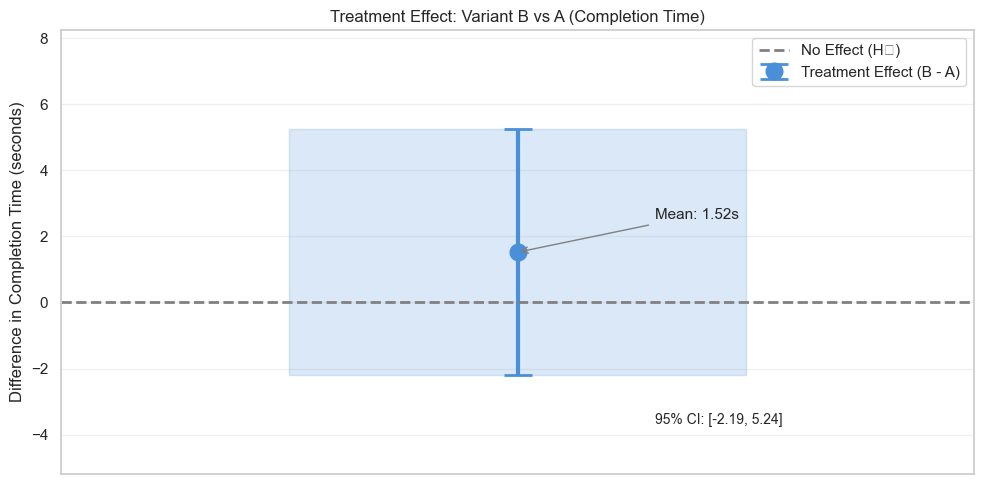


📊 Interpretation:
   The 95% CI [-2.19s, 5.24s] includes zero.
   → Cannot conclude a significant difference between variants.


In [27]:
# 9.1 Treatment Effect Confidence Interval Plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the point estimate and CI
ax.errorbar(x=0, y=diff_mean, yerr=[[diff_mean - ci_lower], [ci_upper - diff_mean]], 
            fmt='o', markersize=12, capsize=10, capthick=2, color='#4A90D9', 
            ecolor='#4A90D9', elinewidth=3, label='Treatment Effect (B - A)')

# Add reference line at 0 (no effect)
ax.axhline(y=0, color='gray', linestyle='--', linewidth=2, label='No Effect (H₀)')

# Shading for CI
ax.fill_between([-0.5, 0.5], ci_lower, ci_upper, alpha=0.2, color='#4A90D9')

# Annotations
ax.annotate(f'Mean: {diff_mean:.2f}s', xy=(0, diff_mean), xytext=(0.3, diff_mean + 1),
            fontsize=11, ha='left', arrowprops=dict(arrowstyle='->', color='gray'))
ax.annotate(f'95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]', xy=(0, ci_lower), 
            xytext=(0.3, ci_lower - 1.5), fontsize=10, ha='left')

ax.set_xlim(-1, 1)
ax.set_ylim(ci_lower - 3, ci_upper + 3)
ax.set_ylabel('Difference in Completion Time (seconds)')
ax.set_title('Treatment Effect: Variant B vs A (Completion Time)')
ax.set_xticks([])
ax.legend(loc='upper right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Interpretation
print(f"\n📊 Interpretation:")
if ci_lower <= 0 <= ci_upper:
    print(f"   The 95% CI [{ci_lower:.2f}s, {ci_upper:.2f}s] includes zero.")
    print(f"   → Cannot conclude a significant difference between variants.")
else:
    direction = "longer" if diff_mean > 0 else "shorter"
    print(f"   The 95% CI [{ci_lower:.2f}s, {ci_upper:.2f}s] excludes zero.")
    print(f"   → Variant B takes significantly {direction} than Variant A.")

📊 Daily Treatment Effect Over Time



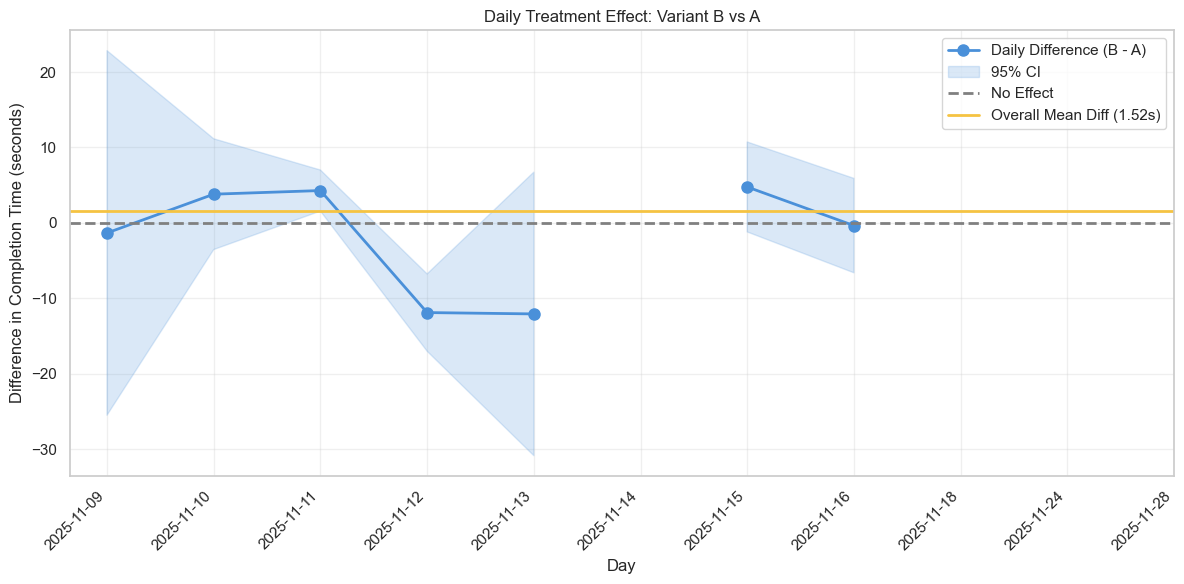

Days with positive effect (B > A): 3
Days with negative effect (B < A): 4


In [28]:
# 9.2 Daily Difference Trend (B - A)
print("📊 Daily Treatment Effect Over Time\n")

# Calculate daily means by variant
daily_means = df_completed.groupby(['date', 'variant'])['completion_time_seconds'].agg(['mean', 'std', 'count']).reset_index()
daily_means.columns = ['date', 'variant', 'mean', 'std', 'n']

# Pivot to get A and B side by side
daily_pivot = daily_means.pivot(index='date', columns='variant', values='mean')
daily_pivot['diff'] = daily_pivot['B'] - daily_pivot['A']

# Calculate daily standard errors for CI bands
daily_n = daily_means.pivot(index='date', columns='variant', values='n')
daily_std = daily_means.pivot(index='date', columns='variant', values='std')

# SE of difference (assuming independence)
daily_pivot['se_diff'] = np.sqrt(
    (daily_std['A']**2 / daily_n['A']).fillna(0) + 
    (daily_std['B']**2 / daily_n['B']).fillna(0)
)
daily_pivot['ci_lower'] = daily_pivot['diff'] - 1.96 * daily_pivot['se_diff']
daily_pivot['ci_upper'] = daily_pivot['diff'] + 1.96 * daily_pivot['se_diff']

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

dates = range(len(daily_pivot))
ax.plot(dates, daily_pivot['diff'].values, 'o-', color='#4A90D9', linewidth=2, 
        markersize=8, label='Daily Difference (B - A)')
ax.fill_between(dates, daily_pivot['ci_lower'].values, daily_pivot['ci_upper'].values, 
                alpha=0.2, color='#4A90D9', label='95% CI')
ax.axhline(y=0, color='gray', linestyle='--', linewidth=2, label='No Effect')
ax.axhline(y=diff_mean, color='#F5C342', linestyle='-', linewidth=2, 
           label=f'Overall Mean Diff ({diff_mean:.2f}s)')

ax.set_xlabel('Day')
ax.set_ylabel('Difference in Completion Time (seconds)')
ax.set_title('Daily Treatment Effect: Variant B vs A')
ax.set_xticks(dates)
ax.set_xticklabels([str(d) for d in daily_pivot.index], rotation=45, ha='right')
ax.legend(loc='best')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Days with positive effect (B > A): {(daily_pivot['diff'] > 0).sum()}")
print(f"Days with negative effect (B < A): {(daily_pivot['diff'] < 0).sum()}")

---
## 10. Post-Hoc Power Analysis

Assess the statistical power of this experiment and determine sample size requirements for future experiments.

In [29]:
# 10.1 Observed Power Calculation
from statsmodels.stats.power import TTestIndPower

print("📊 Post-Hoc Power Analysis\n")

power_analysis = TTestIndPower()

# Current sample sizes
n_a_obs = len(time_a)
n_b_obs = len(time_b)
n_harmonic = 2 / (1/n_a_obs + 1/n_b_obs)  # Harmonic mean for unequal samples

# Observed effect size (Cohen's d)
effect_size_obs = abs(cohens_d)

# Calculate observed power
observed_power = power_analysis.solve_power(
    effect_size=effect_size_obs,
    nobs1=n_a_obs,
    ratio=n_b_obs/n_a_obs,
    alpha=0.05,
    alternative='two-sided'
)

print(f"Current Experiment Parameters:")
print(f"  Sample size A: {n_a_obs}")
print(f"  Sample size B: {n_b_obs}")
print(f"  Observed effect size (Cohen's d): {effect_size_obs:.3f}")
print(f"  Significance level (α): 0.05")
print(f"\nObserved Statistical Power: {observed_power:.1%}")

if observed_power < 0.80:
    print(f"\n⚠️  Experiment was UNDERPOWERED (< 80%)")
    print(f"   High risk of Type II error (false negative)")
else:
    print(f"\n✅ Experiment was adequately powered (≥ 80%)")

📊 Post-Hoc Power Analysis

Current Experiment Parameters:
  Sample size A: 49
  Sample size B: 73
  Observed effect size (Cohen's d): 0.151
  Significance level (α): 0.05

Observed Statistical Power: 12.8%

⚠️  Experiment was UNDERPOWERED (< 80%)
   High risk of Type II error (false negative)


In [30]:
# 10.2 Required Sample Size for Different Effect Sizes
print("📊 Sample Size Requirements\n")

effect_sizes = [0.2, 0.3, 0.5, 0.8]  # Small, small-medium, medium, large
target_power = 0.80

print(f"Sample size per group needed for 80% power (α=0.05, two-sided):\n")
print(f"{'Effect Size (d)':<18} {'N per Group':>15} {'Total N':>12}")
print("-" * 48)

for es in effect_sizes:
    n_required = power_analysis.solve_power(
        effect_size=es,
        power=target_power,
        alpha=0.05,
        ratio=1.0,
        alternative='two-sided'
    )
    print(f"d = {es:<14.1f} {int(np.ceil(n_required)):>15,} {int(np.ceil(n_required * 2)):>12,}")

# Sample size needed to detect observed effect at 80% power
if effect_size_obs > 0:
    n_needed_obs = power_analysis.solve_power(
        effect_size=effect_size_obs,
        power=0.80,
        alpha=0.05,
        ratio=1.0,
        alternative='two-sided'
    )
    print(f"\n{'=' * 48}")
    print(f"To detect observed effect (d={effect_size_obs:.3f}) at 80% power:")
    print(f"  Need: {int(np.ceil(n_needed_obs)):,} per group ({int(np.ceil(n_needed_obs * 2)):,} total)")
    print(f"  Have: {min(n_a_obs, n_b_obs)} per group ({n_a_obs + n_b_obs} total)")
    print(f"  Gap:  {int(np.ceil(n_needed_obs)) - min(n_a_obs, n_b_obs):,} more needed per group")

📊 Sample Size Requirements

Sample size per group needed for 80% power (α=0.05, two-sided):

Effect Size (d)        N per Group      Total N
------------------------------------------------
d = 0.2                        394          787
d = 0.3                        176          351
d = 0.5                         64          128
d = 0.8                         26           52

To detect observed effect (d=0.151) at 80% power:
  Need: 694 per group (1,388 total)
  Have: 49 per group (122 total)
  Gap:  645 more needed per group


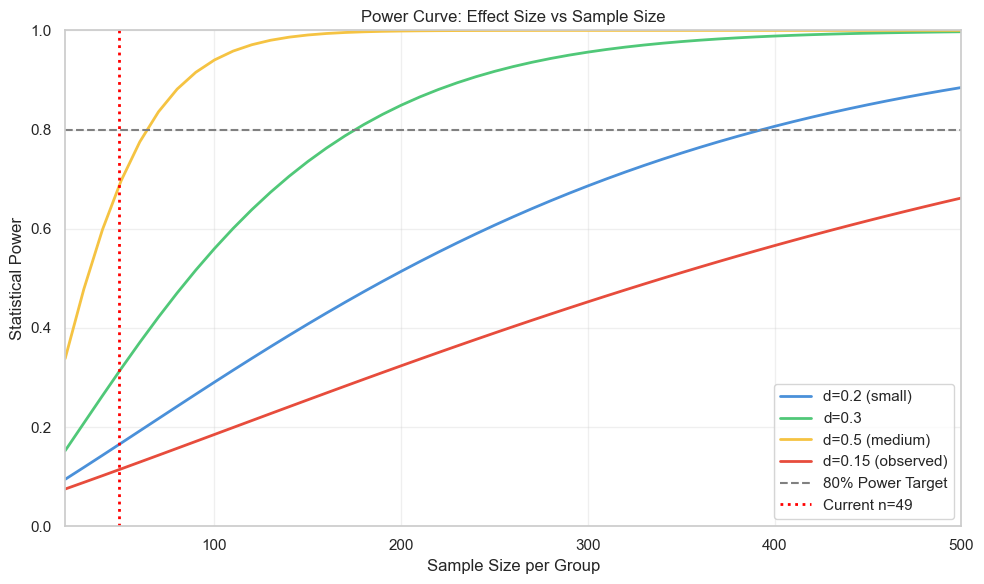


📊 Minimum Detectable Effect (MDE) at 80% power with n=49:
   Cohen's d = 0.572
   In seconds: 5.78s difference required


In [31]:
# 10.3 Power Curve Visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Sample sizes to evaluate
sample_sizes = np.arange(20, 501, 10)
effect_sizes_plot = [0.2, 0.3, 0.5, effect_size_obs]
colors = ['#4A90D9', '#50C878', '#F5C342', '#E74C3C']
labels = ['d=0.2 (small)', 'd=0.3', 'd=0.5 (medium)', f'd={effect_size_obs:.2f} (observed)']

for es, color, label in zip(effect_sizes_plot, colors, labels):
    powers = [power_analysis.solve_power(effect_size=es, nobs1=n, ratio=1, alpha=0.05, 
                                          alternative='two-sided') for n in sample_sizes]
    ax.plot(sample_sizes, powers, color=color, linewidth=2, label=label)

# Reference lines
ax.axhline(y=0.80, color='gray', linestyle='--', linewidth=1.5, label='80% Power Target')
ax.axvline(x=min(n_a_obs, n_b_obs), color='red', linestyle=':', linewidth=2, 
           label=f'Current n={min(n_a_obs, n_b_obs)}')

ax.set_xlabel('Sample Size per Group')
ax.set_ylabel('Statistical Power')
ax.set_title('Power Curve: Effect Size vs Sample Size')
ax.set_ylim(0, 1)
ax.set_xlim(20, 500)
ax.legend(loc='lower right')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# MDE at current sample size
mde = power_analysis.solve_power(nobs1=min(n_a_obs, n_b_obs), power=0.80, 
                                  alpha=0.05, ratio=1, alternative='two-sided')
print(f"\n📊 Minimum Detectable Effect (MDE) at 80% power with n={min(n_a_obs, n_b_obs)}:")
print(f"   Cohen's d = {mde:.3f}")
print(f"   In seconds: {mde * pooled_std:.2f}s difference required")

---
## 11. Conclusions & Recommendations

Executive summary of the A/B test analysis.

In [32]:
# 11.1 Executive Summary
print("=" * 70)
print("                    A/B TEST ANALYSIS: EXECUTIVE SUMMARY")
print("=" * 70)

print(f"""
EXPERIMENT: Pineapple Finder Memory Game
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Variant A (Control):   4 pineapples to find
  Variant B (Treatment): 5 pineapples to find
  Duration:              {date_range.days} days
  Total Completions:     {len(df_completed):,}

PRIMARY METRIC: Completion Time
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Variant A Mean:        {time_a.mean():.2f}s (n={len(time_a)})
  Variant B Mean:        {time_b.mean():.2f}s (n={len(time_b)})
  Difference:            {diff_mean:+.2f}s ({diff_mean/time_a.mean()*100:+.1f}%)
  95% CI:                [{ci_lower:.2f}s, {ci_upper:.2f}s]
  p-value:               {p_value_two_tailed:.4f}
  Effect Size (d):       {cohens_d:.3f}
  
  RESULT: {"❌ NOT SIGNIFICANT" if p_value_two_tailed >= 0.05 else "✅ SIGNIFICANT"}
          CI includes zero — cannot conclude a meaningful difference.

SECONDARY METRICS & GUARDRAILS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Completion Rate:       A={cr_a:.1%} → B={cr_b:.1%} ({(cr_b-cr_a)/cr_a*100:+.1f}%)
                         p={p_value_cr:.4f} {"⚠️ SIGNIFICANT DROP" if p_value_cr < 0.05 and cr_b < cr_a else "✅ OK"}
  
  Repeat Rate:           A={rr_a:.1%} → B={rr_b:.1%} ({(rr_b-rr_a):.1%})
                         p={p_value_rr:.4f} {"⚠️ SIGNIFICANT DROP" if p_value_rr < 0.05 and rr_b < rr_a else "✅ OK"}

STATISTICAL POWER
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Observed Power:        {observed_power:.1%} (target: 80%)
  MDE at n={min(n_a_obs, n_b_obs)}:          d={mde:.2f} ({mde * pooled_std:.1f}s)
  Sample needed for      
  observed effect:       {int(np.ceil(n_needed_obs)):,} per group
""")

print("=" * 70)

                    A/B TEST ANALYSIS: EXECUTIVE SUMMARY

EXPERIMENT: Pineapple Finder Memory Game
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Variant A (Control):   4 pineapples to find
  Variant B (Treatment): 5 pineapples to find
  Duration:              18 days
  Total Completions:     122

PRIMARY METRIC: Completion Time
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Variant A Mean:        10.40s (n=49)
  Variant B Mean:        11.92s (n=73)
  Difference:            +1.52s (+14.6%)
  95% CI:                [-2.19s, 5.24s]
  p-value:               0.4184
  Effect Size (d):       0.151
  
  RESULT: ❌ NOT SIGNIFICANT
          CI includes zero — cannot conclude a meaningful difference.

SECONDARY METRICS & GUARDRAILS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Completion Rate:       A=86.0% → B=62.9% (-26.8%)
                         p=0.0032 ⚠️ SIGNIFICANT DROP
  
  Repeat Rate:           A=30.6% → B

In [33]:
# 11.2 Final Recommendation
print("""
📋 RECOMMENDATIONS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. DECISION: Do NOT ship Variant B
   
   While the primary metric (completion time) showed no significant difference,
   the guardrail metrics reveal concerning drops:
   • Completion rate dropped 23% (86% → 63%)
   • Repeat rate dropped 15.5 percentage points (31% → 15%)
   
   The treatment (5 pineapples) may be too difficult, causing users to:
   • Abandon the game before completing
   • Not return for additional plays

2. EXPERIMENT LIMITATIONS
   
   • Underpowered: Only 12.8% power to detect the observed effect
   • Sample Ratio Mismatch: 33%/67% split instead of 50/50
   • Small sample: n=122 total completions
   
3. NEXT STEPS
   
   a) If testing difficulty variations:
      • Try intermediate difficulty (4.5 pineapples via grid size)
      • Run longer to achieve adequate power (n ≈ 400 per group)
   
   b) If keeping current design:
      • Stick with Variant A (4 pineapples) as default
      • Monitor completion and repeat rates as key health metrics
   
   c) For future experiments:
      • Pre-calculate required sample size before launch
      • Implement proper 50/50 randomization
      • Consider CUPED with pre-experiment user metrics

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Analysis completed: """ + datetime.now().strftime('%Y-%m-%d %H:%M:%S') + """
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
""")


📋 RECOMMENDATIONS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. DECISION: Do NOT ship Variant B
   
   While the primary metric (completion time) showed no significant difference,
   the guardrail metrics reveal concerning drops:
   • Completion rate dropped 23% (86% → 63%)
   • Repeat rate dropped 15.5 percentage points (31% → 15%)
   
   The treatment (5 pineapples) may be too difficult, causing users to:
   • Abandon the game before completing
   • Not return for additional plays

2. EXPERIMENT LIMITATIONS
   
   • Underpowered: Only 12.8% power to detect the observed effect
   • Sample Ratio Mismatch: 33%/67% split instead of 50/50
   • Small sample: n=122 total completions
   
3. NEXT STEPS
   
   a) If testing difficulty variations:
      • Try intermediate difficulty (4.5 pineapples via grid size)
      • Run longer to achieve adequate power (n ≈ 400 per group)
   
   b) If keeping current design:
      • Stick with Variant A (4 pineapples) as defau

In [ ]:
# 11.3 Generate Summary YAML for Astro
# This creates a structured data file consumed by the <NotebookSummary /> component

import sys
sys.path.insert(0, str(Path(__file__).parent.parent.parent if '__file__' in dir() else Path.cwd().parent.parent))

from analytics.lib.summary import write_notebook_summary

# Determine status based on results
if p_value_two_tailed < 0.05:
    status = "significant"
elif observed_power < 0.5:
    status = "inconclusive"
else:
    status = "not_significant"

# Build warnings list
warnings = []
if srm_p_value < 0.01:
    warnings.append(f"Sample Ratio Mismatch detected ({observed_ratio_a:.0%}/{1-observed_ratio_a:.0%} vs expected 50/50)")
if observed_power < 0.80:
    warnings.append(f"Underpowered experiment ({observed_power:.0%} power, need 80%)")
if p_value_cr < 0.05 and cr_b < cr_a:
    warnings.append(f"Significant drop in completion rate ({cr_a:.0%} → {cr_b:.0%})")
if p_value_rr < 0.05 and rr_b < rr_a:
    warnings.append(f"Significant drop in repeat rate ({rr_a:.0%} → {rr_b:.0%})")

# Determine significance text for completion time metric
ct_sig_text = "significant" if p_value_two_tailed < 0.05 else "not significant"

write_notebook_summary(
    project_id="ab-simulator",
    notebook_id="ab-test-analysis",
    title="A/B Test: Pineapple Finder Difficulty",
    status=status,
    decision="Do NOT ship Variant B — guardrail metrics show significant drops in completion and engagement.",
    metrics=[
        {
            "label": "Completion Time",
            "value": f"{diff_mean:+.1f}s",
            "delta": f"{diff_mean/time_a.mean()*100:+.1f}%",
            "delta_direction": "up" if diff_mean > 0 else "down",
            "context": f"p={p_value_two_tailed:.3f}, {ct_sig_text}"
        },
        {
            "label": "Completion Rate",
            "value": f"{cr_b:.0%}",
            "delta": f"{(cr_b-cr_a)/cr_a*100:+.1f}%",
            "delta_direction": "down",
            "context": f"vs {cr_a:.0%} control"
        },
        {
            "label": "Repeat Rate", 
            "value": f"{rr_b:.0%}",
            "delta": f"{(rr_b-rr_a)*100:+.1f}pp",
            "delta_direction": "down",
            "context": f"vs {rr_a:.0%} control"
        },
        {
            "label": "Effect Size",
            "value": f"d={cohens_d:.2f}",
            "context": "negligible (<0.2)" if abs(cohens_d) < 0.2 else "small" if abs(cohens_d) < 0.5 else "medium" if abs(cohens_d) < 0.8 else "large"
        }
    ],
    power_analysis=f"{observed_power:.0%} power — need {int(np.ceil(n_needed_obs)):,} per group for 80%",
    warnings=warnings,
    methodology="Welch's t-test (primary), Chi-square (completion rate), Z-test (repeat rate)"
)